# 07.1 Poisson Processes and Compound Poisson Jumps
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**:

- Introduce the Poisson process as a basic jump-counting process.
- Build it from exponential waiting times and list its key properties.
- Define the compound Poisson process and compute its mean / variance.
- Simulate Poisson and compound Poisson paths in Python.
- Connect these objects to jump–diffusion models used later in the chapter.

**This notebook**: 

Isolates the jump frequencies and jump amplitudes.

## 1. Counting rare events

Examples:

- number of defaults in a credit portfolio,
- number of big price shocks in a day,
- number of claims in insurance,
- number of jumps in a jump–diffusion.

The Poisson process $(N_t)_{t \geq 0}$ is the canonical model:

- $N_t$ = number of events that have occurred up to time $t$,
- jumps happen at random times,
- between jumps, the process is flat,
- jumps are always of size 1.

**Important**: The waiting times between events are exponential and independent.


## 2. Construction and basic properties

### 2.1 Construction from exponential waiting times

Let $(T_i)_{i \geq 1}$ be i.i.d. exponential($\lambda$) random variables (waiting times between events).

Define the jump times:

$$\tau_n = \sum_{i=1}^{n} T_i, \quad n \geq 1.$$

Then define:

$$N_t = \sum_{n \geq 1} \mathbb{1}_{\{\tau_n \leq t\}}, \quad t \geq 0.$$

This $(N_t)_{t \geq 0}$ is a Poisson process of intensity $\lambda > 0$:

- $N_t$ counts how many $\tau_n$ have occurred before time $t$,
- $\tau_n$ = time of the $n$-th jump.

## 2.2 Distribution

For each fixed time $t \geq 0$:

$$P(N_t = n) = e^{-\lambda t} \frac{(\lambda t)^n}{n!}, \quad n = 0, 1, 2, \ldots$$

This is a Poisson distribution with parameter $\lambda t$.

**Mean and variance:**

$$\mathbb{E}[N_t] = \lambda t, \quad \text{Var}(N_t) = \lambda t.$$

**Moment generating function:**

$$\mathbb{E}[s^{N_t}] = e^{\lambda t(s-1)}, \quad s > 0.$$

## 2.3 Important properties

1. **Independent increments:**  
    For $s > 0$, $N_{t+s} - N_t$ is independent of $\mathcal{F}_t$.

2. **Stationary increments:**  
    The law of $N_{t+s} - N_t$ depends only on $s$, not on $t$.

3. **Jump sizes:**  
    $\Delta N_t \in \{0, 1\}$, no multiple jumps at the same time.

4. **Stopping times:**  
    Every $\tau_n$ is a stopping time.

5. **Memoryless waiting times:**  
    The exponential law implies:
    $$P(T_1 > u + v \mid T_1 > u) = P(T_1 > v).$$

These properties make the Poisson process the canonical "jump clock" in continuous-time models.


## 3. Compound Poisson Processes

Sometimes, we don't just count events — each event carries a random size.

Let $(U_j)_{j \geq 1}$ be i.i.d. random variables (jump amplitudes), with distribution $\nu$, independent of $(N_t)$.

Define:

$$
Z_t = \sum_{j=1}^{N_t} U_j, \quad t \geq 0.
$$

Then $(Z_t)$ is a **compound Poisson process**:

- When $N_t$ jumps by 1, $Z_t$ jumps by $U_j$,
- Between jumps, $Z_t$ is constant,
- Number of jumps up to $t$ is still Poisson($\lambda t$).

### Moments

$$
\mathbb{E}[Z_t] = \lambda t \, \mathbb{E}[U_1], \quad \text{Var}(Z_t) = \lambda t \, \mathbb{E}[U_1^2].
$$

In expectation, there are $\lambda t$ jumps up to time $t$, each contributing on average $\mathbb{E}[U_1]$, and with squared amplitude $\mathbb{E}[U_1^2]$.


# 4. Simulating a Poisson process

## 4.1 Simulating jump times via exponential waiting times

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [26]:
def simulate_poisson_path(lmbda, T):
    """
    Simulate one Poisson process (N_t) on [0, T]
    using exponential inter-arrival times.
    """
    jump_times = []
    t = 0.0
    while True:
        # exponential waiting time
        w = np.random.exponential(scale=1.0 / lmbda)
        t += w
        if t > T:
            break
        jump_times.append(t)
    jump_times = np.array(jump_times)

    # Build the step function path
    times = np.concatenate(([0.0], jump_times, [T]))
    counts = np.arange(len(times))  # 0,1,2,...,N_T
    return times, counts

## 4.2 Plot a few sample paths

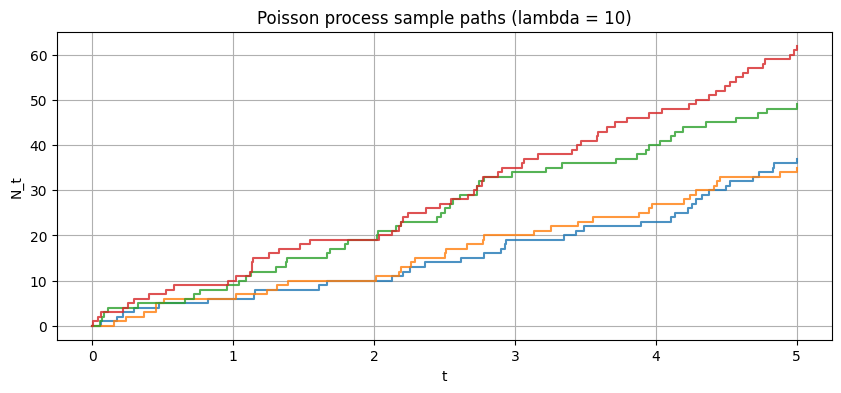

In [148]:
lmbda = 10
T = 5

plt.figure(figsize=(10, 4))

for _ in range(4):
    times, counts = simulate_poisson_path(lmbda=lmbda, T=T)
    plt.step(times, counts, where="post", alpha=0.8)

plt.xlabel("t")
plt.ylabel("N_t")
plt.title(f"Poisson process sample paths (lambda = {lmbda})")
plt.grid(True)
plt.show()

Each curve shows the cumulative number of jumps up to time $t$; the paths increase by unit steps, remain monotone, and end around $N_5 \approx 50$ because $\mathbb{E}[N_5] = \lambda T = 10 \cdot 5 = 50$. That is to say:
- Vertical jumps of height 1: each event adds exactly one count,
- Frequent jumps: because $\lambda = 10$ is high,
- Total count at $t=5$: fluctuates around 50, as expected from the theoretical mean.


# 5. Simulating a compound Poisson process

Here we choose, for example, Gaussian jump sizes $U_j \sim \mathcal{N}(m, s^2)$


In [125]:
def simulate_compound_poisson_path(lmbda, T, jump_mean, jump_std):
    """
    Simulate a compound Poisson process (Z_t) on [0, T].
    Jump times: Poisson(lambda).
    Jump sizes: Normal(jump_mean, jump_std).
    """
    # Simulate Poisson jump times
    jump_times = []
    t = 0.0
    while True:
        w = np.random.exponential(scale=1.0 / lmbda)
        t += w
        if t > T:
            break
        jump_times.append(t)
    jump_times = np.array(jump_times)

    # Jump sizes
    n_jumps = len(jump_times)
    jump_sizes = np.random.normal(loc=jump_mean, scale=jump_std, size=n_jumps)

    # Build path Z_t
    times = np.concatenate(([0.0], jump_times, [T]))
    Z = np.zeros_like(times)
    cumulative = 0.0
    for i in range(1, len(times)):
        if i - 1 < n_jumps:
            cumulative += jump_sizes[i - 1]
        Z[i] = cumulative

    return times, Z, jump_times, jump_sizes

## 5.1 Plot a few compound Poisson paths

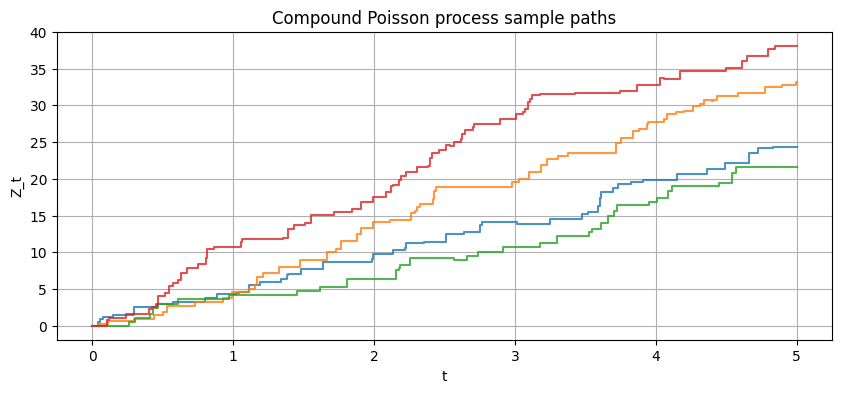

In [134]:
lmbda = 10
T = 5.0

plt.figure(figsize=(10, 4))

for _ in range(4):
    times, Z, jump_times, jump_sizes = simulate_compound_poisson_path(
        lmbda=lmbda, T=T, jump_mean=0.5, jump_std=0.3
    )
    plt.step(times, Z, where="post", alpha=0.8)

plt.xlabel("t")
plt.ylabel("Z_t")
plt.title("Compound Poisson process sample paths")
plt.grid(True)
plt.show()

Each curve shows the cumulative sum of random jump sizes, so the jump times follow the same Poisson structure, but the heights vary because each jump size is drawn from a Normal distribution. So:

- same random arrival times as $N_t$,
- but step heights are no longer 1, they vary (normal noise),
- resulting in more irregular, more volatile paths.


# 6. Empirical mean vs theoretical mean

We can quickly check that $\mathbb{E}[Z_t] \approx \lambda t \mathbb{E}[U_1]$.


In [146]:
def simulate_Z_T(lmbda, T, jump_mean, jump_std, n_paths=10_000):
    Z_T = np.zeros(n_paths)
    for i in range(n_paths):
        _, Z, _, _ = simulate_compound_poisson_path(
            lmbda=lmbda, T=T, jump_mean=jump_mean, jump_std=jump_std
        )
        Z_T[i] = Z[-1]  # value at time T
    return Z_T

lmbda = 1.0
T = 5.0
jump_mean = 0.5
jump_std = 0.2

Z_T_samples = simulate_Z_T(lmbda, T, jump_mean, jump_std, n_paths=5000)

emp_mean = Z_T_samples.mean()
emp_var = Z_T_samples.var()

theo_mean = lmbda * T * jump_mean
theo_var = lmbda * T * (jump_std**2 + jump_mean**2)

print(f"Empirical mean  ≈ {emp_mean:.4f}")
print(f"Theoretical mean = {theo_mean:.4f}")
print(f"Empirical var   ≈ {emp_var:.4f}")
print(f"Theoretical var  = {theo_var:.4f}")

Empirical mean  ≈ 2.5026
Theoretical mean = 2.5000
Empirical var   ≈ 1.4669
Theoretical var  = 1.4500


The empirical mean and variance match the theoretical values extremely well, confirming that the compound Poisson simulator behaves correctly, the small differences come purely from Monte-Carlo noise of order 
$$1/\sqrt{10000}$$
